In [ ]:
!pip install scalecast

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scalecast.Forecaster import Forecaster
from scalecast.AnomalyDetector import AnomalyDetector
from scalecast.SeriesTransformer import SeriesTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM
from keras.optimizers import Adam
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
data = pd.read_csv('BrentOilPrices.csv')
print('Informasi data : \n',data.info())
print('Jumlah Data kosong: \n',data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9011 entries, 0 to 9010
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9011 non-null   object 
 1   Price   9011 non-null   float64
dtypes: float64(1), object(1)
memory usage: 140.9+ KB
Informasi data : 
 None
Jumlah Data kosong: 
 Date     0
Price    0
dtype: int64


In [4]:
data.head() # data yang dimiliki adalah data harian (dimulai dari hari kerja senin - jumat)

,Date,Price
0,20-May-87,18.63
1,21-May-87,18.45
2,22-May-87,18.55
3,25-May-87,18.60
4,26-May-87,18.63


### Anomaly Detection

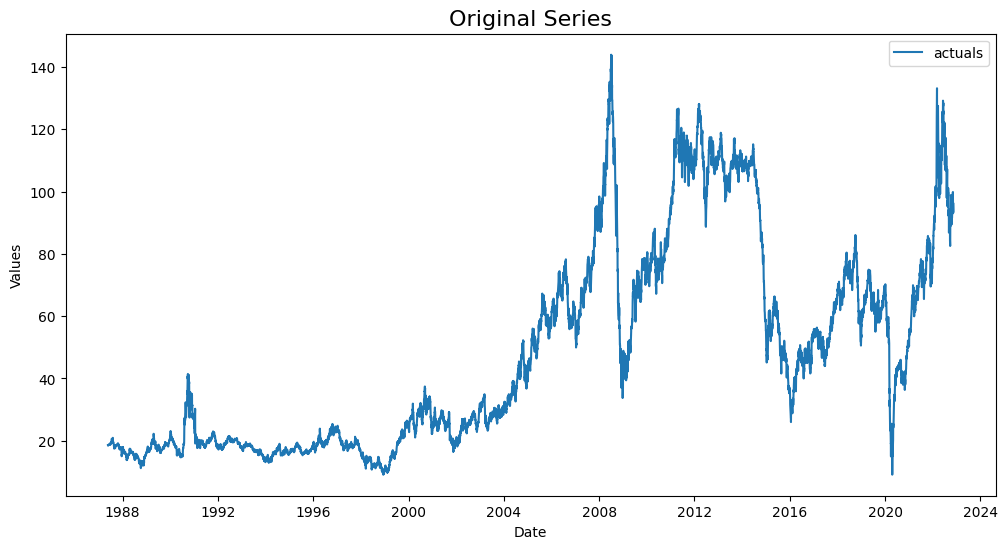

In [5]:
f = Forecaster(
    y=data['Price'],
    current_dates= data['Date']
)
f.plot()
plt.title('Original Series',size=16)
plt.show()

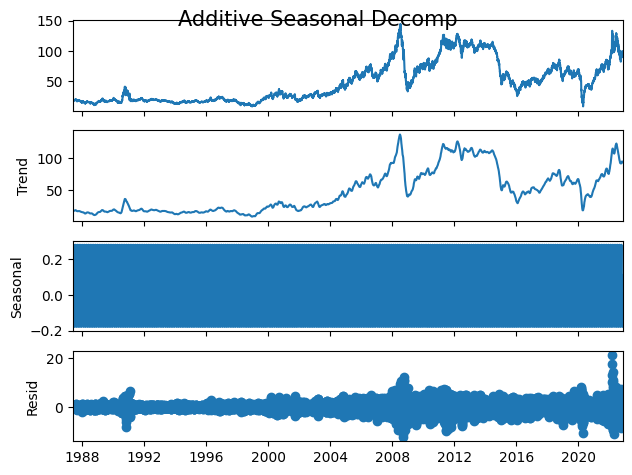

In [6]:
detector1 = AnomalyDetector(f)
f.seasonal_decompose(extrapolate_trend='freq', period =30).plot()
plt.suptitle('Additive Seasonal Decomp', size=15)
plt.show()

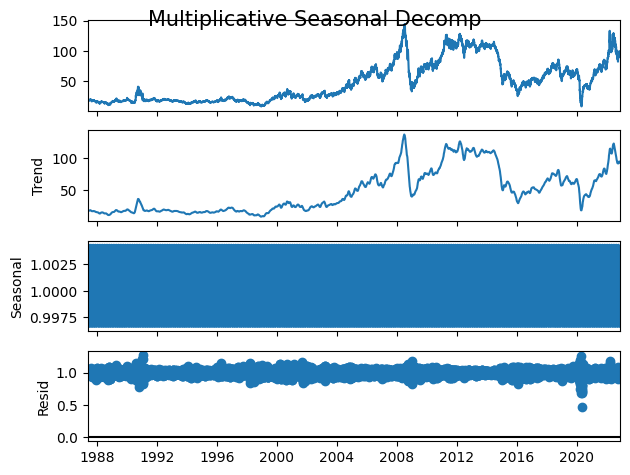

In [7]:
f.seasonal_decompose(
    model='multiplicative',
    period = 30,
    extrapolate_trend='freq'
).plot()
plt.suptitle('Multiplicative Seasonal Decomp',size=15)
plt.show()

In [8]:
detector1.EstimatorDetect(
    estimator='lstm',
    future_dates=30, # how many forecast steps to train into the lstm? default is 1
    cilevel=.99,
    lags=29,
    epochs=10,
    lstm_layer_sizes=(50,40,30),
    dropout=(0,0,0),
    verbose=0,
)


280/280 [==============================] - 4s 13ms/step


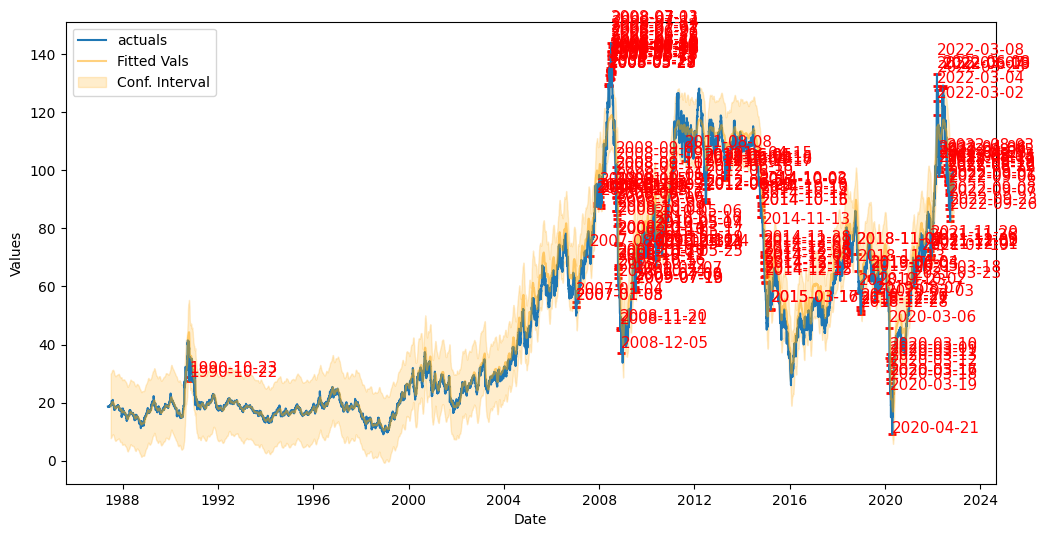

In [9]:
detector1.plot_anom()
plt.show()

In [10]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9011 entries, 1987-05-20 to 2022-11-14
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   9011 non-null   float64
dtypes: float64(1)
memory usage: 140.8 KB


In [11]:
montly_data = data.resample('M').mean()
montly_data.head()

,Price
Date,
1987-05-31,18.580000
1987-06-30,18.860476
1987-07-31,19.856522
1987-08-31,18.979524
1987-09-30,18.313182


Text(0.5, 1.0, 'Data Montly Price')

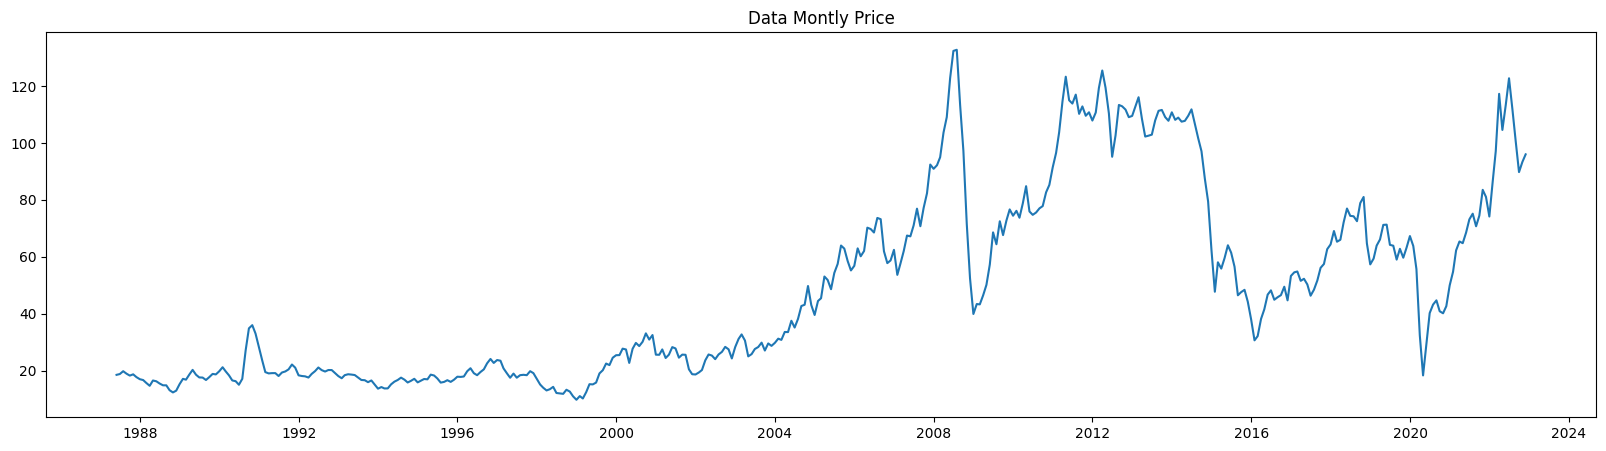

In [12]:
plt.figure(figsize=(20,5))
plt.plot(montly_data)
plt.title('Data Montly Price')

Check For Stationery

In [13]:
from statsmodels.tsa.stattools import adfuller
def ad_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print('1. ADF : ',dftest[0])
  print('2. P-Value : ',dftest[1])
  print('3. Num of Lags : ',dftest[2])
  print('4. Num of Observations User for ADF Regression and Critical Value Calculation : ',dftest[3])
  print('5. Critical Values : ')
  for key , val in dftest[4].items():
    print('\t', key, " : ", val)


def calculate_mae(actual, predicted):
  return np.mean(np.abs(actual-predicted))

def calculate_mape(actual, predicted):
  return 100*np.mean(np.abs((actual - predicted)/ actual))

def calculate_mad(data):
  return np.mean(np.abs(data - np.mean(data)))

In [14]:
ad_test(data['Price'])

1. ADF :  -1.9938560113924675
2. P-Value :  0.28927350489340287
3. Num of Lags :  29
4. Num of Observations User for ADF Regression and Critical Value Calculation :  8981
5. Critical Values : 
	 1%  :  -3.4310783342658615
	 5%  :  -2.861861876398633
	 10%  :  -2.566941329781918


Nilai ADF lebih positif dibandingkan nilai Critical Values, p-value berada diatas standar p-value senilai 0.05, oleh karena itu data tidak menolak hipotesis yang berarti bersifat non-stationer.

### Normalisasi

In [15]:
# melakukan Normalisasi
scale = StandardScaler()
data['Price'] = scale.fit_transform(data['Price'].values.reshape(-1,1))

In [16]:
data

,Price
Date,
1987-05-20,-0.906644
1987-05-21,-0.912122
1987-05-22,-0.909079
1987-05-25,-0.907557
1987-05-26,-0.906644
...,...
2022-11-08,1.473881
2022-11-09,1.358233
2022-11-10,1.394754


In [17]:
def create_lstm_dataset(data, time_steps=5):
  df_as_np = data.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-time_steps):
    row = [a for a in df_as_np[i:i+5]]
    X.append(row)
    label = df_as_np[i+5]
    y.append(label)
  return np.array(X), np.array(y)

In [18]:
time_steps = 5
X, y = create_lstm_dataset(data, time_steps)
X.shape , y.shape

((9006, 5, 1), (9006, 1))

In [19]:
# membagi dataset
X_train, y_train = X[:8500], y[:8500]
X_val , y_val = X[8500:8900], y[8500:8900]
X_test, y_test = X[8900:], y[8900:]
X_train.shape , y_train.shape , X_val.shape , y_val.shape , X_test.shape, y_test.shape

((8500, 5, 1), (8500, 1), (400, 5, 1), (400, 1), (106, 5, 1), (106, 1))

In [20]:
model =Sequential()
model.add(InputLayer((5,1)))
model.add(LSTM(128))
model.add (Dense(8, 'relu'))
model.add(Dense(1,'linear'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 128)               66560     
                                                                 
 dense_1 (Dense)             (None, 8)                 1032      
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 67601 (264.07 KB)
Trainable params: 67601 (264.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
cp = ModelCheckpoint('model/', save_best_only=True) # untuk mencari model terbaik
model.compile(loss =MeanSquaredError(), optimizer=Adam(learning_rate =0.001), metrics =[RootMeanSquaredError()])

In [31]:
model.fit(X_train,y_train, validation_data=(X_val, y_val),epochs =50, callbacks=[cp])

Epoch 1/50
266/266 [==============================] - 22s 60ms/step - loss: 0.0014 - root_mean_squared_error: 0.0381 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0770
Epoch 2/50
266/266 [==============================] - 7s 26ms/step - loss: 0.0014 - root_mean_squared_error: 0.0380 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0770
Epoch 3/50
266/266 [==============================] - 9s 33ms/step - loss: 0.0014 - root_mean_squared_error: 0.0380 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0769
Epoch 4/50
266/266 [==============================] - 5s 18ms/step - loss: 0.0014 - root_mean_squared_error: 0.0380 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0769
Epoch 5/50
266/266 [==============================] - 3s 12ms/step - loss: 0.0014 - root_mean_squared_error: 0.0380 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0770
Epoch 6/50
266/266 [==============================] - 3s 12ms/step - loss: 0.0014 - root_mean_squared_error: 0.0380 - val_loss: 0.0059

In [32]:
from tensorflow.keras.models import load_model # mensave model
model_Lstm = load_model('model/')

In [33]:
# melakukan reshape pada kolom y_train
y_train_flatten = y_train.flatten()
# mebandingkan hasil predik model dengan data actual
train_prediction= model_Lstm.predict(X_train).flatten() # mengubah ke array 1dimensi
train_result = pd.DataFrame(data = {'Trian Prediction':train_prediction, 'Actual':y_train_flatten})
train_result

266/266 [==============================] - 4s 13ms/step


,Trian Prediction,Actual
0,-0.909153,-0.907557
1,-0.907872,-0.907557
2,-0.908207,-0.908166
3,-0.908786,-0.906036
4,-0.908362,-0.905123
...,...,...
8495,-0.286233,-0.227972
8496,-0.264311,-0.187800
8497,-0.229011,-0.180191
8498,-0.189568,-0.190539


Hasil predik cukup model cukup baik, karena hasil prediksi mendekati nilai actual. Semakin mendekati nol nilai selisih antara predik dan actual maka model semakin bagus.

Text(0.5, 1.0, 'Train Predict vc Actual')

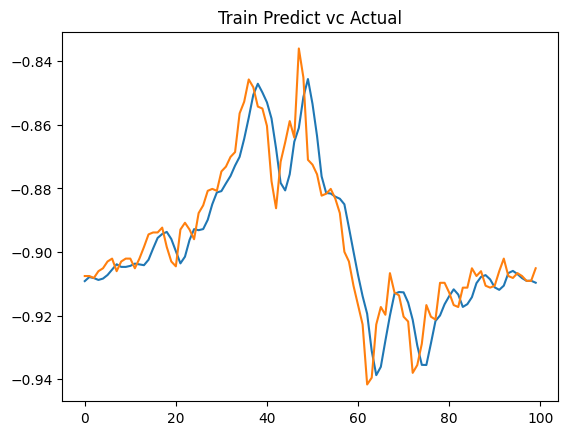

In [34]:
# memvisualisasikan hasil
plt.plot(train_result['Trian Prediction'][:100])
plt.plot(train_result['Actual'][:100])
plt.title('Train Predict vc Actual')

In [35]:
# melakukan reshape pada kolom y_train
y_val_flatten = y_val.flatten()
# mebandingkan hasil predik model dengan data actual
val_prediction= model_Lstm.predict(X_val).flatten() # mengubah ke array 1dimensi
val_result = pd.DataFrame(data = {'Val Prediction':val_prediction, 'Actual':y_val_flatten})
val_result

13/13 [==============================] - 0s 5ms/step


,Val Prediction,Actual
0,-0.193579,-0.173800
1,-0.192476,-0.178974
2,-0.186886,-0.167714
3,-0.174348,-0.162236
4,-0.163902,-0.140932
...,...,...
395,2.427717,2.436196
396,2.433425,2.404849
397,2.418701,2.435283
398,2.420011,2.392067


Text(0.5, 1.0, 'Validation Predict vc Actual')

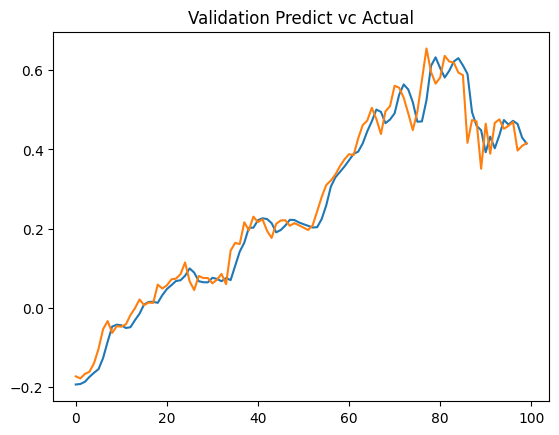

In [27]:
# memvisualisasikan hasil
plt.plot(val_result['Val Prediction'][:100])
plt.plot(val_result['Actual'][:100])
plt.title('Validation Predict vc Actual')

In [28]:
# melakukan reshape pada kolom y_train
y_test_flatten = y_test.flatten()
# mebandingkan hasil predik model dengan data actual
test_prediction= model_Lstm.predict(X_test).flatten() # mengubah ke array 1dimensi
test_result = pd.DataFrame(data = {'Test Prediction':test_prediction, 'Actual':y_test_flatten})
test_result

4/4 [==============================] - 0s 5ms/step


,Test Prediction,Actual
0,2.345656,2.354329
1,2.338775,2.154684
2,2.213941,2.125163
3,2.140706,2.133076
4,2.114620,2.042688
...,...,...
101,1.557259,1.473881
102,1.524274,1.358233
103,1.430846,1.394754
104,1.383725,1.459273


Text(0.5, 1.0, 'Test Predict vc Actual')

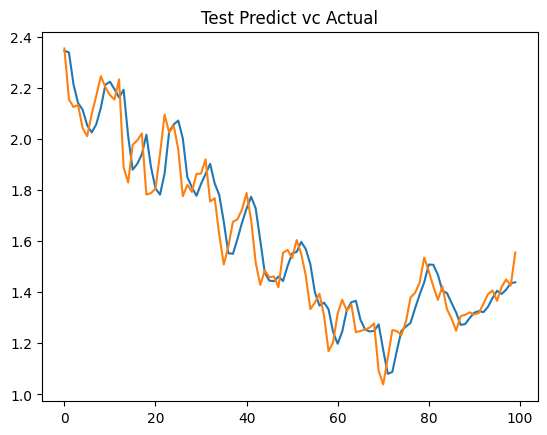

In [29]:
# memvisualisasikan hasil
plt.plot(test_result['Test Prediction'][:100])
plt.plot(test_result['Actual'][:100])
plt.title('Test Predict vc Actual')